**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (100 points + 20 bonus points)  
Author: Luca and Umut

In [0]:
# Group number: 33
# Lynn Le, s4596390
# Ankur Ankan, s4753828
# Eleonora Scarfo, s1028886
# Virginia Meijer, s1024024

In [3]:
!pip install tqdm
!apt -y -q install cuda-libraries-dev-9-2
!pip install -q cupy-cuda92 chainer
!pip install librosa

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cublas-dev-9-2 9.2.148.1-1 [50.4 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cufft-dev-9-2 9.2.148-1 [106 MB]
Get:3 https://developer.download.nvidia.com/compute/cuda/

In [1]:
!ls

sample_data


In [0]:
from chainer import cuda, datasets, serializers
from chainer.dataset import DatasetMixin, concat_examples
from chainer.iterators import MultithreadIterator
import chainer
from chainer import optimizers
import chainer.functions as F
import chainer.links as L
import cupy
import numpy as np
import tqdm

This is the decoder class. It transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and y is latents.

Task: (10 points)

- Implement the decoder class for a variational autoencoder. Note that the decoder should output the Gaussian distribution parameters (mean and variance per pixel) of images rather than images themselves.

In [0]:
class Decoder(chainer.ChainList):
    def __init__(self, in_size): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        super(Decoder, self).__init__(
            # pass your decoder layers here
            L.Linear(in_size=in_size, out_size=128),
            L.Linear(in_size=None, out_size=7*7*32),
            L.Deconvolution2D(in_channels=32, out_channels=16, ksize=3),
            L.Deconvolution2D(in_channels=16, out_channels=1, ksize=3),
            L.Linear(in_size=None, out_size=28*28),
            L.Linear(in_size=None, out_size=28*28)
        )

    def __call__(self, x):
        h = F.normalize(F.leaky_relu(self[0](x)))
        h = F.normalize(F.leaky_relu(F.reshape(self[1](x), [batch_size, 32, 7, 7])))
        h = F.unpooling_2d(F.normalize(F.leaky_relu(self[2](h))), ksize=(2, 2))
        h = F.unpooling_2d(F.normalize(F.leaky_relu(self[3](h))), ksize=(2, 2))
        mean = F.normalize(self[4](h))
        var = F.normalize(self[5](h))
        return mean, var

This is the encoder class. It transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [0]:
class Encoder(chainer.ChainList):
    def __init__(self, out_size): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        super(Encoder, self).__init__(
            # pass your encoder layers here
            L.Convolution2D(in_channels=1, out_channels=32, ksize=3, pad=1),
            L.Convolution2D(in_channels=32, out_channels=64, ksize=3, pad=1),
            L.Linear(in_size=None, out_size=128),
            L.Linear(in_size=None, out_size=out_size),
            L.Linear(in_size=None, out_size=out_size)
        )

    def __call__(self, x):
        h = F.normalize(F.leaky_relu(self[0](x)))
        h = F.max_pooling_2d(F.normalize(F.leaky_relu(self[1](h))), ksize=(2, 2))
        h = F.dropout(h, 0.25)
        
        # Flatten
        h_shape = h.shape
        h = F.reshape(h, [h_shape[0], h_shape[1]*h_shape[2]*h_shape[3]])
        
        h = F.normalize(F.leaky_relu(self[2](h)))
        h = F.dropout(h, 0.5)
        
        mean = F.normalize(self[3](h))
        std = F.normalize(self[4](h))
        return mean, std

This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)

As input, it gets the following arguments:

mean_y => mean of the encoded features (output of the encoder)  
ln_var_y => log variance of the encoded features (output of the encoder)  
x => input images (mini batch)  
mean_x => mean of the decoded images (output of the decoder)  
ln_var_x => mean of the decoded images (output of the decoder)  

As output, it gives the loss.

- Explain why we use log variance instead of variance. (5 points)

In [0]:
class Loss(object):
    def __call__(self, mean_z, ln_var_z, x, mean_x, ln_var_x):
       
        log_likelihood = chainer.functions.gaussian_nll(x, mean_x, ln_var_x)
        
        kl_D = F.gaussian_kl_divergence(mean_z, ln_var_z)
        
        return log_likelihood + kl_D
    

**Answer to "Explain why we use log variance instead of variance."**

When we compute the likelihood, we do a product over all the likelihoods of individual data points (because we assume them to be independent), but doing product over small numbers would get too small and we will have precision problems. So we convert the likelihood to log-likelihood and do a sum over it instead.


This is the model class. It combines the encoder and the decoder.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)
- Explain why we need to use this trick. (10 points)

In [0]:
class Model(chainer.Chain):
    def __init__(self, decoder, encoder):
        super(Model, self).__init__()

        with self.init_scope():
            self.decoder = decoder
            self.encoder = encoder
        
        self.loss = Loss()
        self.optimizer = optimizers.Adam()
        self.optimizer.setup(self)
        self.training_loss = []
        self.test_loss = []

    def __call__(self, x):
        ln_var_z, mean_z = self.encoder(x)
        
        # Sample latents (z) from the Gaussian with parameters ln_var_z, mean_z by using the reparameterization trick
        samples = cupy.random.normal(size=ln_var_z.shape)
        z = mean_z + (ln_var_z * samples)
        
        ln_var_x, mean_x = self.decoder(z)

        return mean_z, ln_var_z, mean_x, ln_var_x

    def test(self, x):
        with chainer.using_config('train', False):
            # Forward prop
            mean_z, ln_var_z, mean_x, ln_var_x = self(x)
            loss = self.loss(mean_z, ln_var_z, x, mean_x, ln_var_x)

            self.test_loss.append(loss.data)

    def train(self, x):
        with chainer.using_config('train', True):
            mean_z, ln_var_z, mean_x, ln_var_x = self(x)
            loss = self.loss(mean_z, ln_var_z, x, F.reshape(mean_x, [32, 1, 28, 28]), F.reshape(ln_var_x, [32, 1, 28, 28]))
            
            self.cleargrads()
            loss.backward()
            
            self.optimizer.update()
            self.training_loss.append(loss.data)

    def predict(self, x):
        mean_z, ln_var_z, mean_x, ln_var_x = self(x)
        samples = cupy.random.normal(size=ln_var_x.shape)

        y = mean_x + (ln_var_x * samples)
        
        return y

**Answer to "Explain why we need to use the reparameterization trick for sampling latents"**

The encoder produces a mu and a sigma for a gaussian distribution. Instead of sampling from this distribution, we sample from the normal distribution and transform this using sigma and mu to get to the same sample. Because we use multiply and addition for the transformation, this allows backpropagation through the bottleneck. 

This is a helper class to use the Mnist dataset.

In [0]:
class Mnist(DatasetMixin):
    def __init__(self):
        self.dataset = datasets.get_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]

    def get_batch(self, batch_size):
        return self.dataset[np.random.randint(low=0, high=len(self.dataset)-1, size=batch_size)].reshape(batch_size, 1, 28, 28)

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original. (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

In [12]:
dataset = Mnist()

In [13]:
n_epochs = 20
batch_size = 32

encoder = Encoder(out_size=16)
decoder = Decoder(in_size=16)
model = Model(decoder=decoder, encoder=encoder)
model.to_gpu()

In [0]:
import matplotlib.pyplot as plt






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [03:11<1:00:34, 191.30s/it]




 10%|█         | 2/20 [06:22<57:24, 191.35s/it]  




 15%|█▌        | 3/20 [09:34<54:14, 191.41s/it]




 20%|██        | 4/20 [12:45<51:00, 191.29s/it]




 25%|██▌       | 5/20 [15:56<47:49, 191.28s/it]




 30%|███       | 6/20 [19:07<44:37, 191.22s/it]




 35%|███▌      | 7/20 [22:18<41:25, 191.19s/it]




 40%|████      | 8/20 [25:29<38:14, 191.19s/it]




 45%|████▌     | 9/20 [28:41<35:05, 191.38s/it]




 50%|█████     | 10/20 [31:53<31:54, 191.44s/it]




 55%|█████▌    | 11/20 [35:04<28:43, 191.44s/it]




 60%|██████    | 12/20 [38:17<25:33, 191.70s/it]




 65%|██████▌   | 13/20 [41:28<22:21, 191.67s/it]




 70%|███████   | 14/20 [44:39<19:09, 191.53s/it]




 75%|███████▌  | 15/20 [47:50<15:56, 191.36s/it]




 80%|████████  | 16/20 [51:02<12:45, 191.47s/it]




 85%|████████▌ | 17/20 [54:13<09:34, 191.39s/it]




 90%|█████████ | 18/20 [57:25<06:22, 191.44s/it]




 95

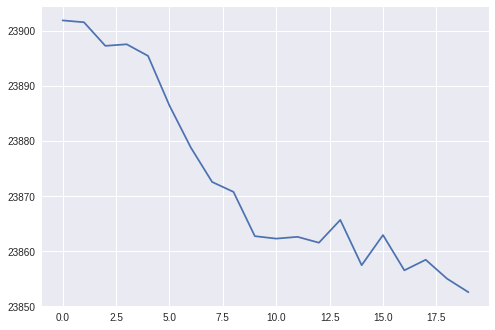

In [208]:
for epoch in tqdm.tqdm(range(n_epochs)):
    n_batches = len(dataset) // batch_size
    for i in range(n_batches):
        batch = model.xp.array(dataset.get_batch(batch_size=batch_size))
        model.train(batch)

plt.plot(range(0,n_epochs), np.array(model.training_loss).reshape(n_epochs, n_batches).mean(axis=1))

In [215]:
batch = model.xp.array([dataset.get_example(i).reshape(1, 28, 28) for i in range(batch_size)])
y = model.predict(batch)

# plt.imshow(y)

--Return--
> <ipython-input-215-5c87efd005b3>(2)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) batch.shape
(32, 1, 28, 28)
(Pdb) c


variable([[[[2.4368332e-03 1.0211914e-05 1.1536455e-03 ...
             1.4168157e-03 9.6205855e-05 2.5662454e-03]
            [4.7046487e-06 2.3052944e-03 3.0434334e-05 ...
             9.5802749e-04 6.5213596e-03 7.7578123e-04]
            [5.4867702e-05 5.5963203e-04 1.5905140e-03 ...
             1.0907967e-06 2.5482937e-05 7.1337126e-04]
            ...
            [3.3422068e-05 4.0960449e-04 2.3369051e-03 ...
             6.3575862e-04 5.1361036e-05 1.5032652e-03]
            [8.4216875e-04 2.5132613e-04 1.3028735e-05 ...
             3.0936098e-05 6.0474296e-05 5.7817932e-04]
            [6.8442584e-03 7.9861557e-06 1.2995348e-03 ...
             1.7495591e-03 1.1080161e-04 1.6178765e-05]]]


          [[[3.0557998e-03 2.4687277e-05 9.1341417e-06 ...
             6.5712183e-04 6.9469784e-04 9.6225049e-03]
            [2.1545172e-03 3.9727696e-05 5.9762649e-04 ...
             1.6930929e-03 2.2956792e-03 2.7592669e-03]
            [2.3451294e-03 7.8140751e-05 9.0798590e-04 ...
 

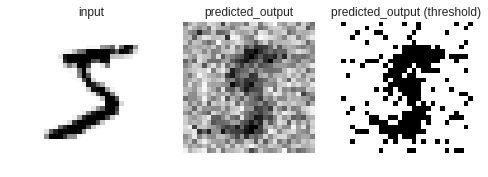

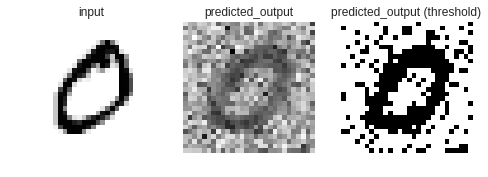

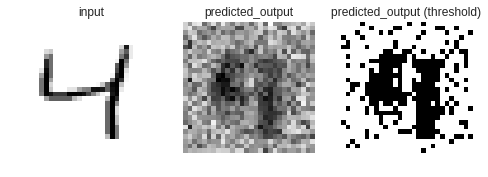

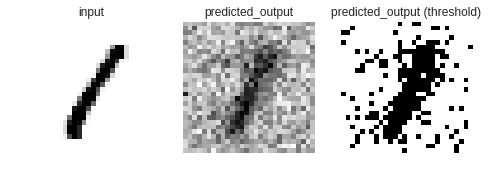

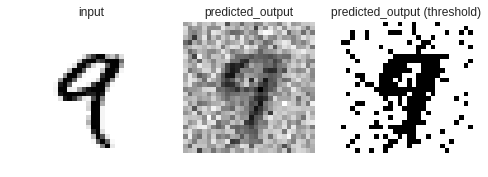

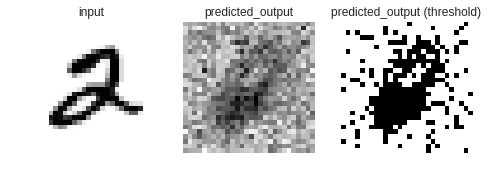

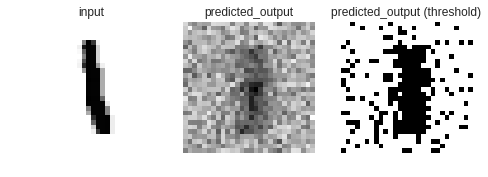

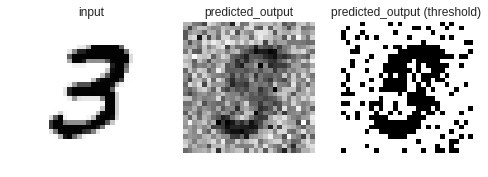

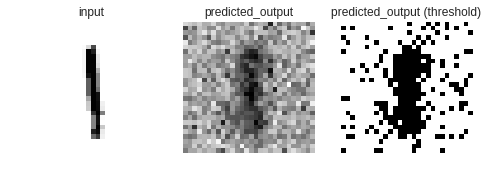

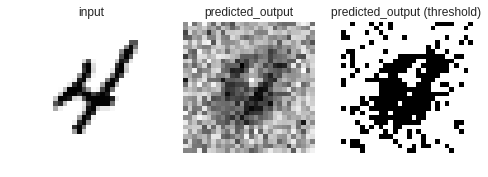

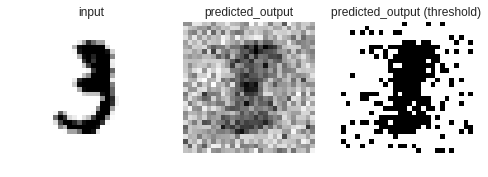

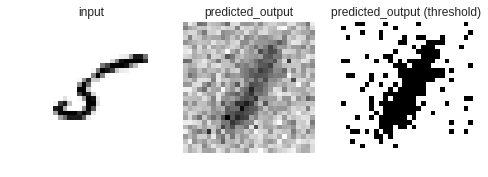

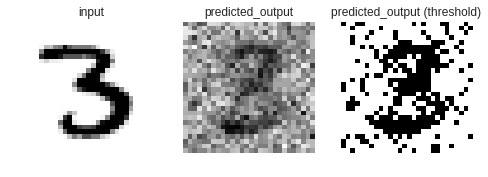

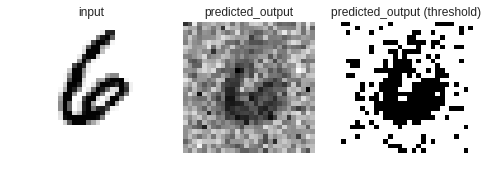

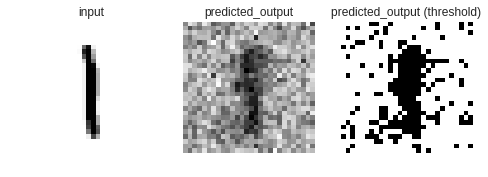

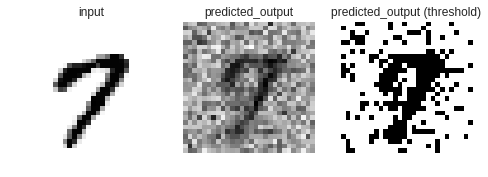

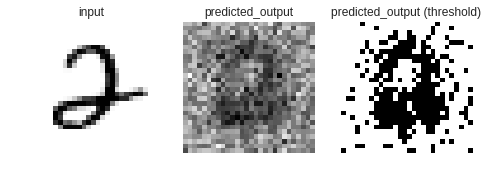

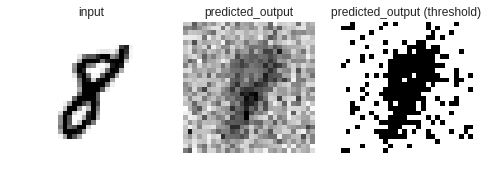

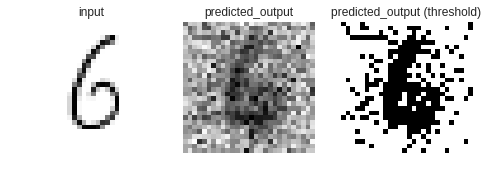

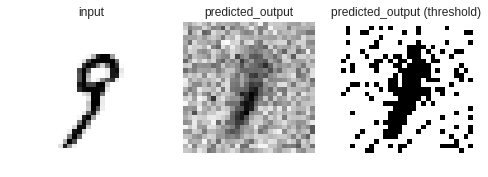

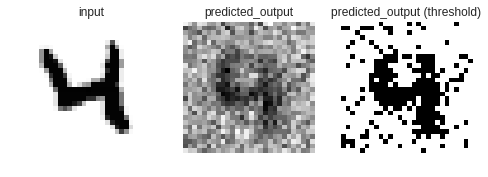

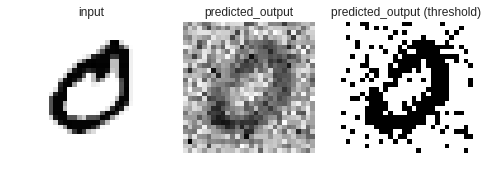

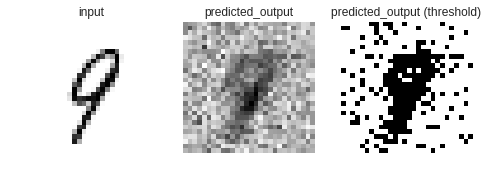

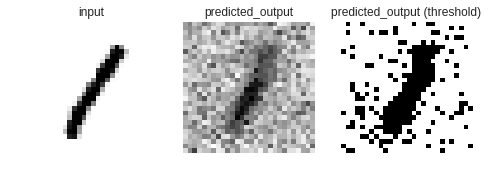

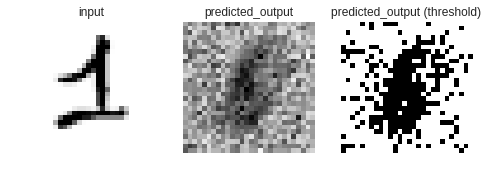

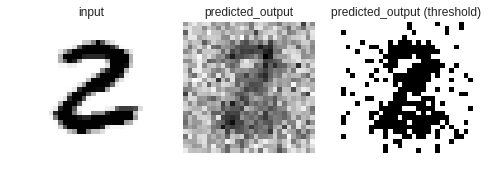

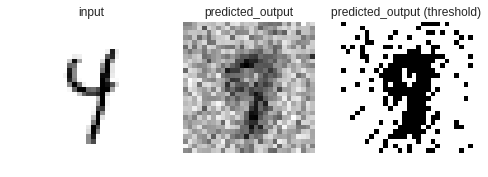

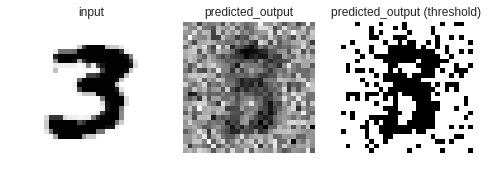

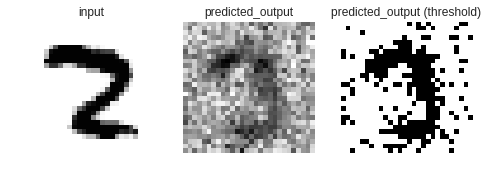

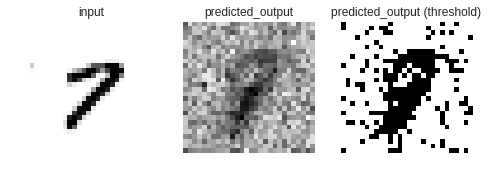

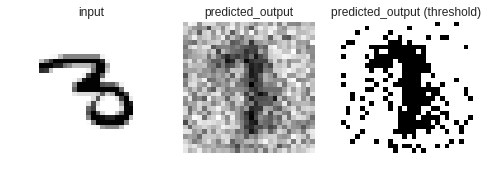

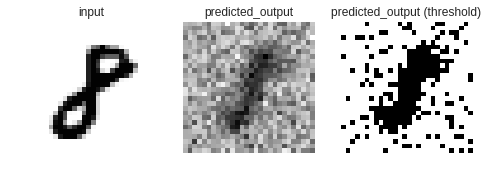

In [217]:
y = y.reshape(32, 28, 28)

for b in range(32):
    plt.subplot(131)
    plt.axis("off")
    plt.title('input')
    plt.imshow(cupy.asnumpy(batch[b,0]))
    
    plt.subplot(132)
    plt.axis("off")
    plt.title('predicted_output')
    plt.imshow(cupy.asnumpy(y[b].data))
    
    plt.subplot(133)
    plt.axis("off")
#     plt.title('predicted_output (log)')
#     plt.imshow(np.log(cupy.asnumpy(y[b].data)))
    plt.title('predicted_output (threshold)')
    plt.imshow(cupy.asnumpy(y[b].data)>0.04)
    plt.show()
# print(y.shape)

**Answer to "How good are the samples? Randomy sample some digits and visualize them."**
The input images are clear and readable. The numbers are clearly black and the background is white, therefore there is a big contrast.



**Answer to "How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original.""**
The reconstruction of the digits are also accurate and it is possible to perceive which numbers are being reconstructed. However, there is alot of noise compared to the input samples.


**Answer to "Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results.""**

See bonus task below for results. The model has more difficulty reconstructing the fashion mnist dataset because the dataset has a larger variation in contrast. For example , for white t shirts, it is not well reconstructed but for black shoes it is. There still is alot of noise.

In [26]:
class Fashion_Mnist(DatasetMixin):
    def __init__(self):
        self.dataset = datasets.get_fashion_mnist(False)[0 if chainer.config.train else 1]

#         self.dataset = datasets.get_mnist()
#         get_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]

    def get_batch(self, batch_size):
        return self.dataset[np.random.randint(low=0, high=len(self.dataset)-1, size=batch_size)].reshape(batch_size, 1, 28, 28)
    
dataset2 = Fashion_Mnist()



```
# This is formatted as code
```

Bonus task: Try the same experiments on a different dataset. (20 bonus points)

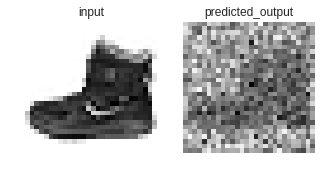

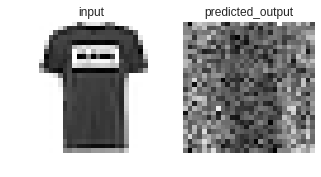

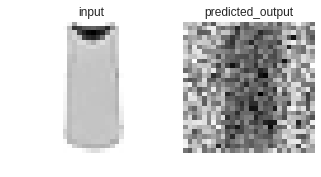

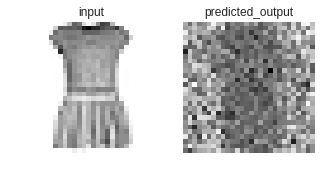

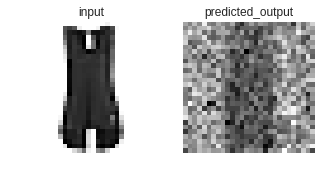

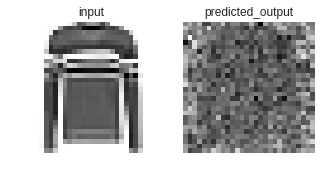

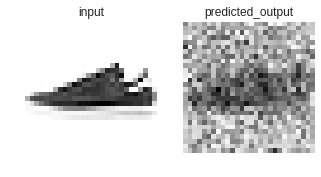

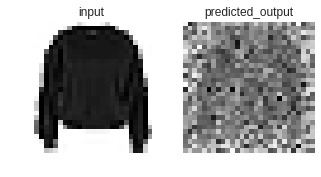

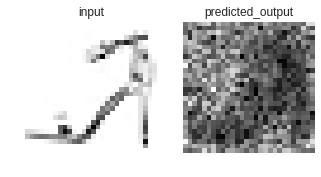

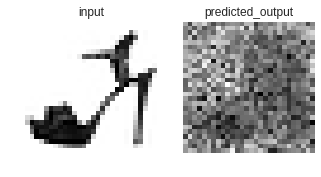

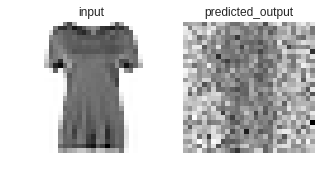

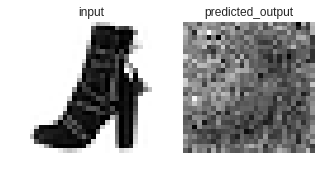

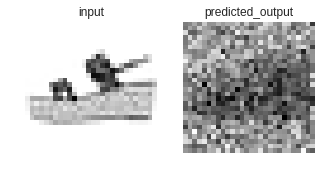

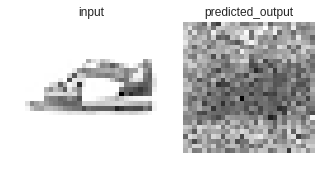

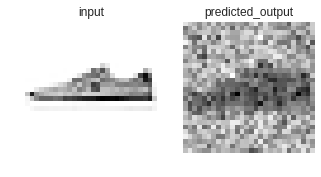

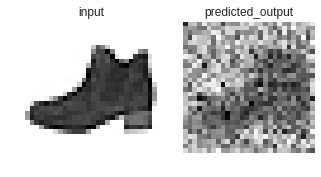

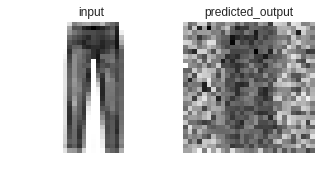

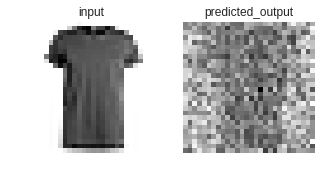

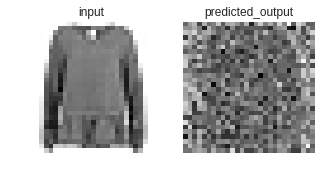

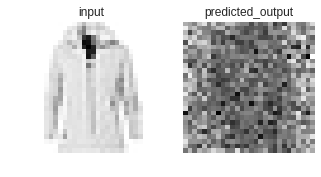

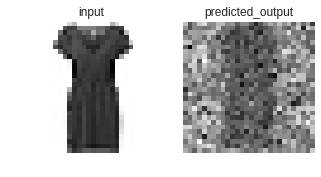

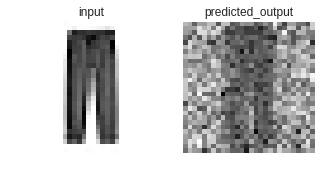

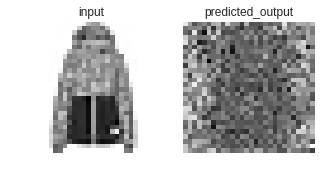

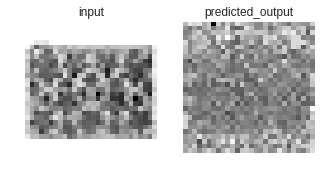

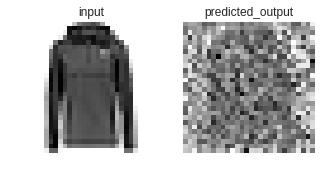

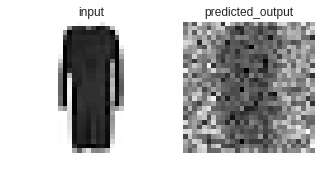

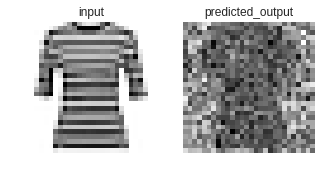

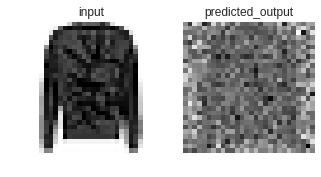

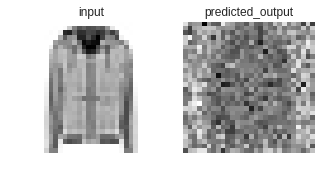

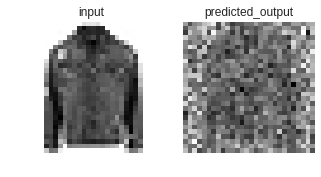

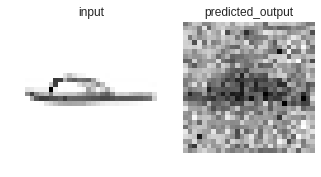

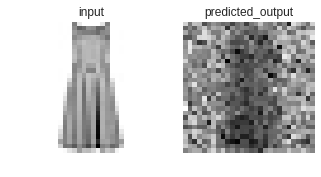

In [59]:
dataset = dataset2

for epoch in tqdm.tqdm(range(n_epochs)):
    n_batches = len(dataset) // batch_size
    for i in range(n_batches):
        batch = model.xp.array(dataset.get_batch(batch_size=batch_size))
        model.train(batch)

plt.plot(range(0,n_epochs), np.array(model.training_loss).reshape(n_epochs, n_batches).mean(axis=1))
batch = model.xp.array([dataset.get_example(i).reshape(1, 28, 28) for i in range(batch_size)])
y = model.predict(batch)

# plt.imshow(y)

y = y.reshape(32, 28, 28)

for b in range(32):
    plt.subplot(131)
    plt.axis("off")
    plt.title('input')
    plt.imshow(cupy.asnumpy(batch[b,0]))
    
    plt.subplot(132)
    plt.axis("off")
    plt.title('predicted_output')
    plt.imshow(cupy.asnumpy(y[b].data))
    
#     plt.subplot(133)
#     plt.axis("off")
# #     plt.title('predicted_output (log)')
# #     plt.imshow(np.log(cupy.asnumpy(y[b].data)))
#     plt.title('predicted_output (threshold)')
#     plt.imshow(cupy.asnumpy(y[b].data)>0.04)
    plt.show()
# print(y.shape)